In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 6.3MB/s 
     |████████████████████████████████| 51kB 5.9MB/s 
     |████████████████████████████████| 1.0MB 22.4MB/s 
     |████████████████████████████████| 51kB 5.2MB/s 
     |████████████████████████████████| 194kB 26.7MB/s 
     |████████████████████████████████| 51kB 5.3MB/s 
     |████████████████████████████████| 40kB 5.0MB/s 
     |████████████████████████████████| 92kB 8.9MB/s 
     |████████████████████████████████| 61kB 6.3MB/s 
     |████████████████████████████████| 51kB 5.8MB/s 
     |████████████████████████████████| 2.6MB 45.0MB/s 
Mounted at /content/gdrive


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from fastai.vision.all import *
from fastai.data.all import *
from fastai.imports import *
from fastai.vision.core import *
from fastai import metrics
import scipy
from scipy import ndimage

In [4]:
def get_tuple_files(path):
    files = get_image_files(path)
    files = files.filter(lambda f: f.name.endswith('vhr.tif'),negate=False)
    return files


In [5]:
def label_func(x):
      return str(x.parents[0]/x.stem[0:23])+"_mask_build.tif";

In [6]:
model_build= load_learner(Path('/content/drive/My Drive/patch-build.pkl'),cpu = True)

model_flood= load_learner(Path('/content/drive/My Drive/patch-flooded.pkl'),cpu = True)


# **PREDICTIONS**

In [ ]:
im=PILImage.create("/content/drive/My Drive/E246000N3305300UTM15R/vhr.tif")
mask1=PILMask.create("/content/drive/My Drive/E246000N3305300UTM15R/buildings1m.tif")
mask2=PILMask.create("/content/drive/My Drive/E246000N3305300UTM15R/flooded1m.tif")

In [10]:
  z=im.reshape(1024,1024,resample=Image.BICUBIC)

  z=image2tensor(z)
  z1=z[:,0:512,0:512]
  z2=z[:,0:512,512:1024]
  z3=z[:,512:1024,0:512]
  z4=z[:,512:1024,512:1024]

  z1=z1.permute((1,2,0))
  z2=z2.permute((1,2,0))
  z3=z3.permute((1,2,0))
  z4=z4.permute((1,2,0))

  im1=PILImage.create(z1.cpu().numpy())
  im2=PILImage.create(z2.cpu().numpy())
  im3=PILImage.create(z3.cpu().numpy())
  im4=PILImage.create(z4.cpu().numpy())

In [13]:
x1=torch.cat([model_build.predict(im1)[0],model_build.predict(im2)[0]],dim=1)
x2=torch.cat([model_build.predict(im3)[0],model_build.predict(im4)[0]],dim=1)
x=torch.cat([x1,x2],dim=0)

In [18]:
y1=torch.cat([model_flood.predict(im1)[0],model_flood.predict(im2)[0]],dim=1)
y2=torch.cat([model_flood.predict(im3)[0],model_flood.predict(im4)[0]],dim=1)
y=torch.cat([y1,y2],dim=0)

Text(0.5, 1.0, 'VHR Image')

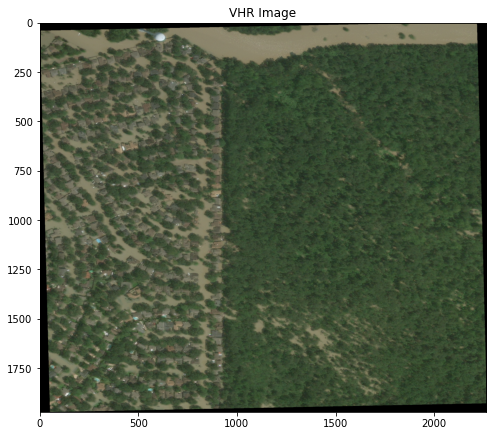

In [33]:
fig, axarr = plt.subplots(1,1, figsize=(8,8), sharex=True, sharey=True)
axarr.imshow(im)
axarr.set_title(f'VHR Image')

Text(0.5, 1.0, 'Flood Damage Mask Prediction')

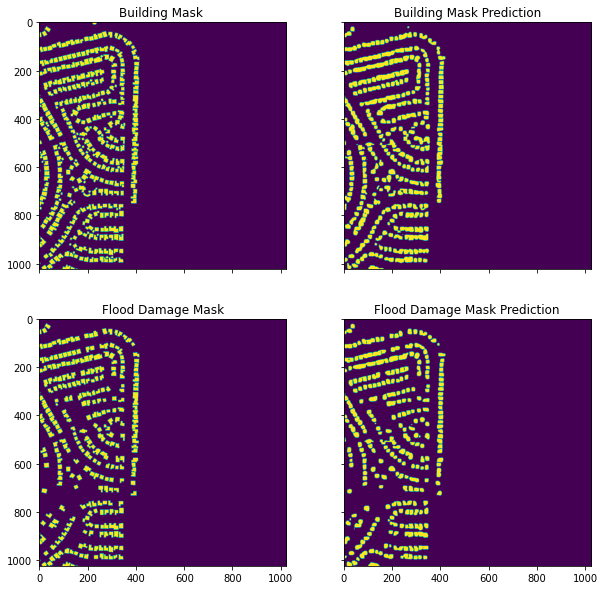

In [26]:
fig, axarr = plt.subplots(2,2, figsize=(10,10), sharex=True, sharey=True)


axarr[0][0].imshow(mask1.reshape(1024,1024,resample=3))
axarr[0][0].set_title(f'Building Mask ')


axarr[0][1].imshow(x)
axarr[0][1].set_title(f'Building Mask Prediction')

axarr[1][0].imshow(mask2.reshape(1024,1024,resample=3))
axarr[1][0].set_title(f'Flood Damage Mask')


axarr[1][1].imshow(y)
axarr[1][1].set_title(f'Flood Damage Mask Prediction')





# **SIMPLE UI**

In [ ]:
up=fastbook.widgets.FileUpload()
up

FileUpload(value={}, description='Upload')

In [ ]:
out=fastbook.widgets.Output()
bt=fastbook.widgets.Button(description="Segment")
bt_fld=fastbook.widgets.Button(description="Damaged Segment")

In [ ]:
out

Output()

In [ ]:
with out:
  out.clear_output() 
  im=PILImage.create(up.data[-1])
  display(im.resize((512,512),resample=3))
  
  z=im.reshape(1024,1024,resample=Image.BICUBIC)

  z=image2tensor(z)
  z1=z[:,0:512,0:512]
  z2=z[:,0:512,512:1024]
  z3=z[:,512:1024,0:512]
  z4=z[:,512:1024,512:1024]

  z1=z1.permute((1,2,0))
  z2=z2.permute((1,2,0))
  z3=z3.permute((1,2,0))
  z4=z4.permute((1,2,0))

  im1=PILImage.create(z1.cpu().numpy())
  im2=PILImage.create(z2.cpu().numpy())
  im3=PILImage.create(z3.cpu().numpy())
  im4=PILImage.create(z4.cpu().numpy())


def on_click_flood(change):
  print("DAMAGED BUILDINGS")
  y1=torch.cat([model_flood.predict(im1)[0],model_flood.predict(im2)[0]],dim=1)
  y2=torch.cat([model_flood.predict(im3)[0],model_flood.predict(im4)[0]],dim=1)
  y=torch.cat([y1,y2],dim=0)
  plt.imshow(y)

bt_fld.on_click(on_click_flood)


def on_click_segmen(change):
  print("BUILDINGS")
  x1=torch.cat([model_build.predict(im1)[0],model_build.predict(im2)[0]],dim=1)
  x2=torch.cat([model_build.predict(im3)[0],model_build.predict(im4)[0]],dim=1)
  x=torch.cat([x1,x2],dim=0)
  plt.imshow(x)

bt.on_click(on_click_segmen) 

In [ ]:
lb_ch=fastbook.widgets.Label(value="Choose Image File")

In [ ]:
fastbook.widgets.VBox([fastbook.widgets.Label('Select the map image'),up,out,bt,bt_fld,lb_ch])